In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV, LeaveOneOut, LeavePOut, RepeatedKFold, train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler # robust_scale
from sklearn.svm import SVR

In [225]:
#df = pd.read_csv('../elena/barros_2011_training.csv')
raw = pd.read_csv('../data/training_final_latcorr.csv')

## Clean / Reverse Engineer Features
- Electricity generated (kWh)
- Drop redundant columns
- Drop non-lc columns

In [236]:
raw_cols_to_include = [
    #'field_1', 
    #'Name', 
    #'Longitude', 
    #'Latitude', 
    'CO2 (mg C m¯² d¯¹)',
    #'CH4 (mg C m-2 d-1)', 
    #'CO2 (g/kWh)', 
    #'CH4 (g/kWh)',
    #'Area / Electricity', 
    #'Area_km2', 
    'Age', 
    #'Volume_km3',
    #'Areakm2_div_Volkm3', 
    'org_c', 
    'temp_annual_avg',
    'temp_diff_summer_winter_lc',
    #'temp_spring_avg_lc',
    #'temp_spring_avg', 
    #'temp_summer_avg_lc',
    #'temp_summer_avg',
    #'temp_fall_avg_lc', 
    #'temp_fall_avg', 
    #'temp_winter_avg_lc',
    #'temp_winter_avg', 
    'NDVI_annual_avg', 
    #'NDVI_spring_avg_lc',
    #'NDVI_spring_avg', 
    #'NDVI_summer_avg_lc', 
    #'NDVI_summer_avg',
    #'NDVI_fall_avg_lc', 
    #'NDVI_fall_avg', 
    #'NDVI_winter_avg_lc',
    #'NDVI_winter_avg', 
    'npp_annual_avg', 
    #'npp_spring_avg_lc',
    #'npp_spring_avg', 
    #'npp_summer_avg_lc', 
    #'npp_summer_avg',
    #'npp_fall_avg_lc', 
    #'npp_fall_avg', 
    #'npp_winter_avg_lc',
    #'npp_winter_avg',
    'erosion',
    'precip'
]

clean = raw[raw_cols_to_include].copy()

print("raw.shape   =", raw.shape)
print("clean.shape =", clean.shape)

raw.shape   = (154, 44)
clean.shape = (154, 9)


In [237]:
clean['log_co2_emissions'] = np.log(clean['CO2 (mg C m¯² d¯¹)'])


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [238]:
reduced = clean.dropna()
reduced.shape

(120, 10)

In [239]:
#target = 'CO2 (mg C m¯² d¯¹)'
target = 'log_co2_emissions'

features = ['Age', 'org_c', 'temp_annual_avg', 'temp_diff_summer_winter_lc', 
            'NDVI_annual_avg', 'npp_annual_avg', 'erosion', 'precip']

X = reduced[features]
y = reduced[target]

In [240]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [241]:
print("X_train.shape =", X_train.shape)
print("X_test.shape  =", X_test.shape)
print("y_train.shape =", y_train.shape)
print("y_test.shape  =", y_test.shape)

X_train.shape = (90, 8)
X_test.shape  = (30, 8)
y_train.shape = (90,)
y_test.shape  = (30,)


In [181]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knr', KNeighborsRegressor())
])

pipeline.fit(X_train, y_train)

print("Train score =", pipeline.score(X_train, y_train))
print("Test score  =", pipeline.score(X_test, y_test))

Train score = 0.6089452371310761
Test score  = 0.49710373213557973


In [79]:
parameters = {
    'knr__n_neighbors': range(1, round(len(y_train) / 2)),
    'knr__weights': ['uniform', 'distance']
}

my_cv = RepeatedKFold(n_splits=2, n_repeats=10, random_state=0)

grid_search = GridSearchCV(pipeline, parameters, cv=my_cv, n_jobs=-1, scoring='r2') 

grid_search.fit(X_train, y_train)

print("Best score: %0.3f" % grid_search.best_score_)
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

grid_search.best_estimator_.score(X_test, y_test)

Best score: 0.245
	knr__n_neighbors: 5
	knr__weights: 'distance'


0.6083936912199917

## SVM

In [182]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR())
])

pipeline.fit(X_train, y_train)

print("Train score =", pipeline.score(X_train, y_train))
print("Test score  =", pipeline.score(X_test, y_test))

Train score = 0.584585543336138
Test score  = 0.4146479001737358


In [44]:
parameters = {
    'svr__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'svr__C': range(0,11),
    'svr__gamma': ['scale', 'auto']

}

my_cv = RepeatedKFold(n_splits=2, n_repeats=10, random_state=0)

grid_search = GridSearchCV(pipeline, parameters, cv=my_cv, n_jobs=-1, scoring='r2') 

grid_search.fit(X_train, y_train)

print("Best score: %0.3f" % grid_search.best_score_)
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

grid_search.best_estimator_.score(X_test, y_test)

Best score: 0.183
	svr__C: 1
	svr__gamma: 'scale'
	svr__kernel: 'rbf'


0.4146479001737358

In [54]:
# grid_search.best_estimator_.named_steps['svr']

SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

## Random Forest

In [189]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rfr', RandomForestRegressor())
])

pipeline.fit(X_train, y_train)

print("Train score =", pipeline.score(X_train, y_train))
print("Test score  =", pipeline.score(X_test, y_test))

Train score = 0.894923143281758
Test score  = 0.4272549670235195


In [190]:
parameters = {
    "rfr__n_estimators" : range(10, 100, 20),
    "rfr__max_depth" : range(1,6),
    "rfr__max_features" : range(1,6)
}

my_cv = RepeatedKFold(n_splits=2, n_repeats=10, random_state=42)

grid_search = GridSearchCV(pipeline, parameters, cv=my_cv, n_jobs=-1, scoring='r2') 

grid_search.fit(X_train, y_train)

print("Best score: %0.3f" % grid_search.best_score_)
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

grid_search.best_estimator_.score(X_test, y_test)

KeyboardInterrupt: 

In [103]:
grid_search.best_estimator_.named_steps['rfr'].feature_importances_

array([0.3605966 , 0.00679756, 0.05602334, 0.34962233, 0.02847189,
       0.        , 0.01880927, 0.179679  ])

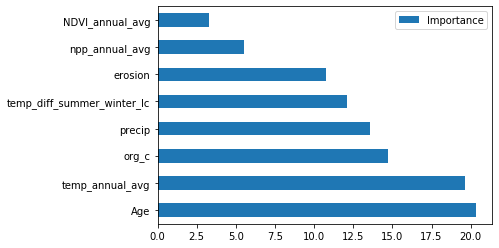

In [191]:
pd.DataFrame(index=X_train.columns,
             data=pipeline.named_steps['rfr'].feature_importances_*100,
             columns=['Importance']).sort_values(by='Importance', ascending=False).plot(kind='barh')